In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import tensorflow as tf
%matplotlib inline 

base_path = '/home/emp/ownCloud/Private/Master/python/Data/BA_Thiel/'
# base_path = '/media/emp/Thiel/BA_Caro/'

feature_path = os.path.join(base_path, 'features.hdf5')

In [2]:
store = pd.HDFStore(feature_path)
features = store['features']
store.close()

In [3]:
features.head(2)

,Header_Pseudonummer,Header_Walzlos,Header_Leitguete,Header_Anzahl_Bloecke_im_Los,Header_Soll_AD,Header_Soll_WD,WAS_Blockmasse,WAS_Blocklaenge,WAS_Oberflaechentemperatur,DHO_Entkohlung,...,SRW_Ha2_peak,SRW_Ha2_Einschwingzeit,SRW_Ha2_Mittel,SRW_Ha2_std,SRW_WD_vdev,SRW_WD_vdeh,SRW_WD_Mittel,SRW_WD_std,SRW_WD_trend,SRW_WD_flaeche
DPRD_ID,,,,,,,,,,,,,,,,,,,,,
24124442,1294224751,71616569,10300,192,25,2.8,189.6,690.1,712.0,1.1096,...,2034.12,66.0,983.246293,174.537636,6.0,5.0,2.163944,0.078727,-0.000030,1500.891326
23594161,1287122151,71609783,10300,79,25,2.8,178.8,653.8,734.0,1.1564,...,1790.58,112.0,1081.444222,168.001019,5.0,5.0,2.155106,0.076665,-0.000101,1429.573371


In [4]:
features.groupby(["Header_Leitguete","Header_Soll_AD","Header_Soll_WD"])["Header_Pseudonummer"].agg(["count"])

count
Header_Leitguete Header_Soll_AD Header_Soll_WD       
10300            25             2.55             5338
                                2.80             6223
                 38             2.60             1434
40200            30             2.70             7994
                 38             2.60             6036

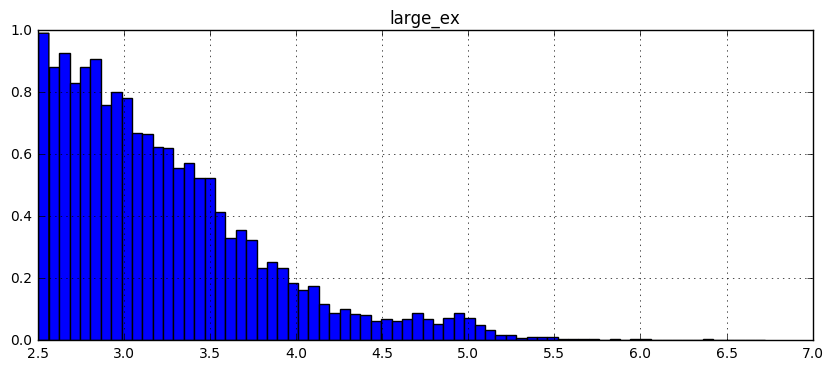

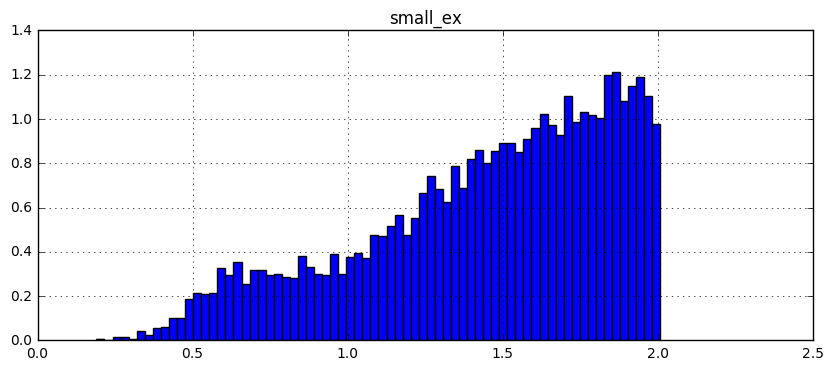

In [5]:
# 2 Gruppen erstellen: Eine für hohe, eine für niedrige Exzentrizität. Das Netz wird später auf die Gruppenlabels (0 oder 1) trainiert
N = 8000
selection = features
g1 = selection.nlargest(N, 'STB_Ex_mitte')
g2 = selection.nsmallest(N, 'STB_Ex_mitte')

fig1, ax1 = plt.subplots(1, 1, figsize=(10, 4))
fig2, ax2 = plt.subplots(1, 1, figsize=(10, 4))
g1.hist(column='STB_Ex_mitte', bins=70, normed=True, ax=ax1)
g2.hist(column='STB_Ex_mitte', bins=70, normed=True, ax=ax2)
ax1.set(title='large_ex')
ax2.set(title='small_ex')

In [6]:
g1['target'] = 0
g2['target'] = 1
g_total = pd.concat([g1, g2])
g_total.head(2)

,Header_Pseudonummer,Header_Walzlos,Header_Leitguete,Header_Anzahl_Bloecke_im_Los,Header_Soll_AD,Header_Soll_WD,WAS_Blockmasse,WAS_Blocklaenge,WAS_Oberflaechentemperatur,DHO_Entkohlung,...,SRW_Ha2_Einschwingzeit,SRW_Ha2_Mittel,SRW_Ha2_std,SRW_WD_vdev,SRW_WD_vdeh,SRW_WD_Mittel,SRW_WD_std,SRW_WD_trend,SRW_WD_flaeche,target
DPRD_ID,,,,,,,,,,,,,,,,,,,,,
23597266,1287168001,71604975,10300,107,25,2.8,186.4,684.2,738.0,1.1224,...,115.0,1092.952026,147.831179,6.0,4.0,2.168239,0.077982,-0.000024,1499.650152,0
23907349,1291342401,71615108,40200,564,38,2.6,150.4,546.7,707.0,1.5032,...,137.0,919.185033,308.272611,3.0,6.0,1.975324,0.070004,-0.000015,1474.291780,0


In [7]:
# Daten Sauber machen (Von Michi)
df=g_total
relNaNsCol = np.array(np.sum(np.isnan(df))/df.shape[0]*100)
# schmeiße zunächst alle Spalten heraus, die mehr als bestimmte Prozent an NaNs haben
spaltenSchranke = 15 # % der NaNs in Spalte
keep = [i for i in np.arange(len(relNaNsCol)) if relNaNsCol[i] <= spaltenSchranke]
dfVV = df[df.columns[keep]] # extrahiere Spalten

# gleiches auf Zeilen anwenden
zeilenSchranke = 5 # % der NaNs in Zeile
relNaNsRow = np.array(dfVV.isnull().sum(axis=1)/dfVV.shape[1]*100)
keep = [i for i in np.arange(len(relNaNsRow)) if relNaNsRow[i] <= zeilenSchranke]
dfVV2 = dfVV.iloc[keep] #extraheire Zeilen

#übrige NaNs mit Mittelwert aus Spalten auffüllen
dfVV2 = dfVV2.fillna(dfVV2.mean())
g_clean = dfVV2.iloc[:,:]
# Ausgabe
print("Daten nach Vorverarbeitung:")
print("Anzahl der Kennwerte: "+str(dfVV2.shape[1]))
print("Anzahl der vermessenen Rohre: "+str(dfVV2.shape[0]))
print("Anzahl der gefahrenen Produkte: "+str(dfVV2.groupby(["Header_Leitguete","Header_Soll_AD","Header_Soll_WD"])["Header_Pseudonummer"].agg(["count"]).shape[0]))
print("Anzahl der Walzlose: "+str(len(pd.unique(dfVV2["Header_Walzlos"]))))
print("\nAuszug:")
dfVV2.head()

Daten nach Vorverarbeitung:
Anzahl der Kennwerte: 81
Anzahl der vermessenen Rohre: 13615
Anzahl der gefahrenen Produkte: 5
Anzahl der Walzlose: 120

Auszug:


,Header_Pseudonummer,Header_Walzlos,Header_Leitguete,Header_Anzahl_Bloecke_im_Los,Header_Soll_AD,Header_Soll_WD,WAS_Blockmasse,WAS_Blocklaenge,WAS_Oberflaechentemperatur,DHO_Entkohlung,...,SRW_Ha2_Einschwingzeit,SRW_Ha2_Mittel,SRW_Ha2_std,SRW_WD_vdev,SRW_WD_vdeh,SRW_WD_Mittel,SRW_WD_std,SRW_WD_trend,SRW_WD_flaeche,target
DPRD_ID,,,,,,,,,,,,,,,,,,,,,
23597266,1287168001,71604975,10300,107,25,2.80,186.4,684.2,738.0,1.1224,...,115.0,1092.952026,147.831179,6.0,4.0,2.168239,0.077982,-0.000024,1499.650152,0
23907349,1291342401,71615108,40200,564,38,2.60,150.4,546.7,707.0,1.5032,...,137.0,919.185033,308.272611,3.0,6.0,1.975324,0.070004,-0.000015,1474.291780,0
23627716,1287480001,71604946,10300,153,25,2.55,176.0,638.9,725.0,1.1314,...,71.0,1066.746923,192.454045,7.0,6.0,1.981085,0.090813,-0.000062,1375.832727,0
24112087,1294090051,71615050,10300,113,25,2.80,177.2,646.4,726.0,1.1390,...,6.0,1076.983140,402.225269,6.0,6.0,2.217356,0.084263,-0.000048,1402.661742,0
23595167,1287142251,71598374,10300,230,25,2.80,184.2,670.3,690.0,1.2072,...,82.0,987.118195,398.031941,7.0,7.0,2.179587,0.094261,-0.000060,1462.089432,0


In [8]:
# Daten für das Netz vorbereiten
X_total = stats.zscore(np.array(g_clean.iloc[:, 6:-1]),axis=0)
y_total = np.array(g_clean.target, dtype=np.bool)
y_total = np.array([y_total, ~y_total]).T  # One Hot encoding der Targets (Ist für das Netz einfacher zu trainieren)

In [9]:
# Split nach Walzlosen, nicht nach Rohren, um auswendiglernen des Netztes zu schlechten Ergebnissen führen zu lassen.
walzlose =np.unique(g_clean.Header_Walzlos)
np.random.shuffle(walzlose)
test_anteil = 0.4
w_test, w_train = np.hsplit(walzlose, [np.asarray(np.floor(test_anteil*len(walzlose)), dtype=np.int)])
test_pattern = np.array(g_clean.Header_Walzlos.isin(w_test))
train_pattern = ~test_pattern

In [10]:
X_test, y_test, X_train, y_train = (X_total[test_pattern, :], y_total[test_pattern, :], X_total[train_pattern, :], y_total[train_pattern, :])
idx = np.random.permutation(X_test.shape[0])
teX = X_test[idx, :]
teY = y_test[idx, :]
idx = np.random.permutation(X_train.shape[0])
trX = X_train[idx, :]
trY = y_train[idx, :]


In [11]:
# Modell für Tensorflow (Feed-Forward mit Dropout, geklaut von hier: https://github.com/nlintz/TensorFlow-Tutorials/blob/master/04_modern_net.ipynb)
def model(X, w_h, w_h2, w_o, p_keep_input, p_keep_hidden):
    X = tf.nn.dropout(X, p_keep_input)
    h = tf.nn.relu(tf.matmul(X, w_h))

    h = tf.nn.dropout(h, p_keep_hidden)
    h2 = tf.nn.relu(tf.matmul(h, w_h2))

    h2 = tf.nn.dropout(h2, p_keep_hidden)

    return tf.matmul(h2, w_o)

def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))

In [15]:
X = tf.placeholder("float", [None, X_total.shape[1]]) # None-Dimension für Batch-Size freihalten
Y = tf.placeholder("float", [None, 2]) # 2 Ausgänge für 2 Klassen da One-Hot kodierung
neurons = 300
w_h = init_weights([X_total.shape[1], neurons])
w_h2 = init_weights([neurons, neurons])
w_o = init_weights([neurons, 2])

p_keep_input = tf.placeholder("float")
p_keep_hidden = tf.placeholder("float")
py_x = model(X, w_h, w_h2, w_o, p_keep_input, p_keep_hidden)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(py_x, Y))
train_op = tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-08).minimize(cost)
# train_op = tf.train.RMSPropOptimizer(0.001, 0.9).minimize(cost)
predict_op = tf.argmax(py_x, 1)

In [16]:
batch_size = 30
with tf.Session() as sess:
    # you need to initialize all variables
    tf.initialize_all_variables().run()

    for i in range(50):
        for start, end in zip(range(0, len(trX), batch_size), range(batch_size, len(trX)+1, batch_size)):
            sess.run(train_op, feed_dict={X: trX[start:end], Y: trY[start:end],
                                          p_keep_input: 0.6, p_keep_hidden: 0.5})
        print('Epoche: ' +  str(i)  + ' Klassifikationsrate: ' + 
              str(np.mean(np.argmax(teY, axis=1) ==
                  sess.run(predict_op, feed_dict={X: teX, Y: teY,
                                                  p_keep_input: 1.0,
                                                  p_keep_hidden: 1.0}))
                 )
              )
    

Epoche: 0 Klassifikationsrate: 0.975960591133
Epoche: 1 Klassifikationsrate: 0.985221674877
Epoche: 2 Klassifikationsrate: 0.988177339901
Epoche: 3 Klassifikationsrate: 0.986009852217
Epoche: 4 Klassifikationsrate: 0.987783251232
Epoche: 5 Klassifikationsrate: 0.987783251232
Epoche: 6 Klassifikationsrate: 0.993891625616
Epoche: 7 Klassifikationsrate: 0.993694581281
Epoche: 8 Klassifikationsrate: 0.994285714286
Epoche: 9 Klassifikationsrate: 0.990738916256
Epoche: 10 Klassifikationsrate: 0.995665024631
Epoche: 11 Klassifikationsrate: 0.991921182266
Epoche: 12 Klassifikationsrate: 0.994679802956
Epoche: 13 Klassifikationsrate: 0.991133004926
Epoche: 14 Klassifikationsrate: 0.996650246305
Epoche: 15 Klassifikationsrate: 0.992906403941
Epoche: 16 Klassifikationsrate: 0.995270935961
Epoche: 17 Klassifikationsrate: 0.99684729064
Epoche: 18 Klassifikationsrate: 0.99645320197
Epoche: 19 Klassifikationsrate: 0.99802955665
Epoche: 20 Klassifikationsrate: 0.996256157635
Epoche: 21 Klassifikations